# Met Éireann Reanalysis - create input data for ModVege

In [1]:
# import libraries
import glob
import os
from datetime import datetime, timezone
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import climag.plot_configs as cplt

In [2]:
# directory of processed MÉRA netCDF files
DATA_DIR = os.path.join("/run/media/nms/MyPassport", "MERA", "netcdf_day")

In [3]:
# list of netCDF variable files
var_list = [
    "11_105_2_0",   # 2 m temperature
    "61_105_0_4",   # total precipitation
    "117_105_0_4",  # global irradiance
    "PET"           # evapotranspiration
]

In [4]:
# dictionary to store Xarray datasets
ds = {}

In [5]:
for var in var_list:
    ds[var] = xr.open_mfdataset(
        glob.glob(os.path.join(DATA_DIR, f"MERA_{var}_day.nc")),
        chunks="auto", decode_coords="all"
    )

In [6]:
# obtain CRS info
data_crs = ds["11_105_2_0"].rio.crs

In [7]:
data_crs

CRS.from_wkt('PROJCS["undefined",GEOGCS["undefined",DATUM["undefined",SPHEROID["undefined",6367470,0]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_1SP"],PARAMETER["latitude_of_origin",53.5],PARAMETER["central_meridian",5],PARAMETER["scale_factor",1],PARAMETER["false_easting",1481641.67696368],PARAMETER["false_northing",537326.063885016],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

In [8]:
# drop the height dimension from the datasets
for v in var_list[:-1]:
    ds[v] = ds[v].isel(height=0)

## View datasets

In [9]:
ds["11_105_2_0"]

<xarray.Dataset>
Dimensions:            (x: 158, y: 166, time: 9131)
Coordinates:
  * x                  (x) float64 4.15e+05 4.175e+05 ... 8.05e+05 8.075e+05
  * y                  (y) float64 4.075e+05 4.1e+05 ... 8.175e+05 8.2e+05
    height             float64 2.0
    Lambert_Conformal  int64 ...
  * time               (time) datetime64[ns] 1981-01-01 ... 2005-12-31
    spatial_ref        int64 ...
Data variables:
    t                  (time, y, x) float32 dask.array<chunksize=(4871, 85, 81), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Mar 22 19:51:04 2023: cdo -s -f nc4c -shifttime,-3hour ...
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...

In [10]:
ds["61_105_0_4"]

<xarray.Dataset>
Dimensions:            (x: 158, y: 166, time: 9131)
Coordinates:
  * x                  (x) float64 4.15e+05 4.175e+05 ... 8.05e+05 8.075e+05
  * y                  (y) float64 4.075e+05 4.1e+05 ... 8.175e+05 8.2e+05
    height             float64 0.0
    Lambert_Conformal  int64 ...
  * time               (time) datetime64[ns] 1981-01-01 ... 2005-12-31
    spatial_ref        int64 ...
Data variables:
    tp                 (time, y, x) float32 dask.array<chunksize=(4871, 85, 81), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Mar 22 16:41:24 2023: cdo -s -f nc4c -shifttime,-3hour ...
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...

In [11]:
ds["117_105_0_4"]

<xarray.Dataset>
Dimensions:            (x: 158, y: 166, time: 9131)
Coordinates:
  * x                  (x) float64 4.15e+05 4.175e+05 ... 8.05e+05 8.075e+05
  * y                  (y) float64 4.075e+05 4.1e+05 ... 8.175e+05 8.2e+05
    height             float64 0.0
    Lambert_Conformal  int64 ...
  * time               (time) datetime64[ns] 1981-01-01 ... 2005-12-31
    spatial_ref        int64 ...
Data variables:
    grad               (time, y, x) float32 dask.array<chunksize=(4871, 85, 81), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Mar 22 21:11:40 2023: cdo -s -f nc4c -shifttime,-3hour ...
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...

In [12]:
ds["PET"]

<xarray.Dataset>
Dimensions:            (x: 158, y: 166, time: 9131)
Coordinates:
  * x                  (x) float64 4.15e+05 4.175e+05 ... 8.05e+05 8.075e+05
  * y                  (y) float64 4.075e+05 4.1e+05 ... 8.175e+05 8.2e+05
    height             float64 ...
    Lambert_Conformal  int64 ...
  * time               (time) datetime64[ns] 1981-01-01 ... 2005-12-31
    spatial_ref        int64 ...
Data variables:
    PET                (time, y, x) float32 dask.array<chunksize=(4756, 86, 82), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...

## Calculate photosynthetically active radiation (PAR)

In [13]:
# Papaioannou et al. (1993) - irradiance ratio
ds["117_105_0_4"] = ds["117_105_0_4"].assign(
    PAR=ds["117_105_0_4"]["grad"] * 0.473
)
ds["117_105_0_4"]["PAR"].attrs["long_name"] = (
    "Surface Photosynthetically Active Radiation"
)
ds["117_105_0_4"]["PAR"].attrs["units"] = "MJ m⁻² day⁻¹"

## Merge datasets

In [14]:
# merge datasets
ds = xr.combine_by_coords(
    [ds["11_105_2_0"], ds["61_105_0_4"], ds["117_105_0_4"], ds["PET"]],
    combine_attrs="drop_conflicts", compat="override"
)

In [15]:
# drop global radiation
ds = ds.drop_vars(["grad"])

In [16]:
# rename other variables
ds = ds.rename({"t": "T", "tp": "PP"})

In [17]:
# assign dataset name
ds.attrs["dataset"] = "IE_MERA_FC3hr_3_day"

In [18]:
# reassign CRS
ds.rio.write_crs(data_crs, inplace=True)

<xarray.Dataset>
Dimensions:            (x: 158, y: 166, time: 9131)
Coordinates:
  * x                  (x) float64 4.15e+05 4.175e+05 ... 8.05e+05 8.075e+05
  * y                  (y) float64 4.075e+05 4.1e+05 ... 8.175e+05 8.2e+05
    height             float64 0.0
    Lambert_Conformal  int64 ...
  * time               (time) datetime64[ns] 1981-01-01 ... 2005-12-31
    spatial_ref        int64 0
Data variables:
    PAR                (time, y, x) float32 dask.array<chunksize=(4871, 85, 81), meta=np.ndarray>
    PET                (time, y, x) float32 dask.array<chunksize=(4756, 86, 82), meta=np.ndarray>
    T                  (time, y, x) float32 dask.array<chunksize=(4871, 85, 81), meta=np.ndarray>
    PP                 (time, y, x) float32 dask.array<chunksize=(4871, 85, 81), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...
    dataset:      IE_MERA_FC3hr_3_day

## Visualise

In [19]:
# Moorepark, Fermoy met station coords
LON, LAT = -8.26389, 52.16389

In [20]:
# transform coordinates from lon/lat to Lambert Conformal Conic
XLON, YLAT = cplt.lambert_conformal.transform_point(
    x=LON, y=LAT, src_crs=ccrs.PlateCarree()
)

In [21]:
def plot_map(data, var, cmap="Spectral_r"):
    """
    Helper function for plotting maps
    """

    plt.figure(figsize=(9, 7))
    ax = plt.axes(projection=cplt.lambert_conformal)
    data.isel(time=120)[var].plot.contourf(
        ax=ax, robust=True, x="x", y="y", levels=10,
        transform=cplt.lambert_conformal,
        cmap=cmap,
        cbar_kwargs={
            "label": (
                data[var].attrs["long_name"] +
                " [" + data[var].attrs["units"] + "]"
            )
        }
    )
    ax.gridlines(
        draw_labels=dict(bottom="x", left="y"),
        color="lightslategrey",
        linewidth=.5,
        x_inline=False,
        y_inline=False
    )
    ax.coastlines(resolution="10m", color="darkslategrey", linewidth=.75)
    ax.set_title(str(data.isel(time=90)["time"].values))
    plt.tight_layout()
    plt.show()

In [22]:
def plot_ts(data, var):
    """
    Helper function for plotting time series
    """

    plt.figure(figsize=(12, 4))
    data_ts = data.sel({"x": XLON, "y": YLAT}, method="nearest")
    data_ts = data_ts.sel(time=slice("1989", "1991"))
    plt.plot(data_ts["time"], data_ts[var])
    plt.title(
        data[var].attrs["long_name"] + " [" + data[var].attrs["units"] + "]"
    )
    plt.tight_layout()
    plt.show()

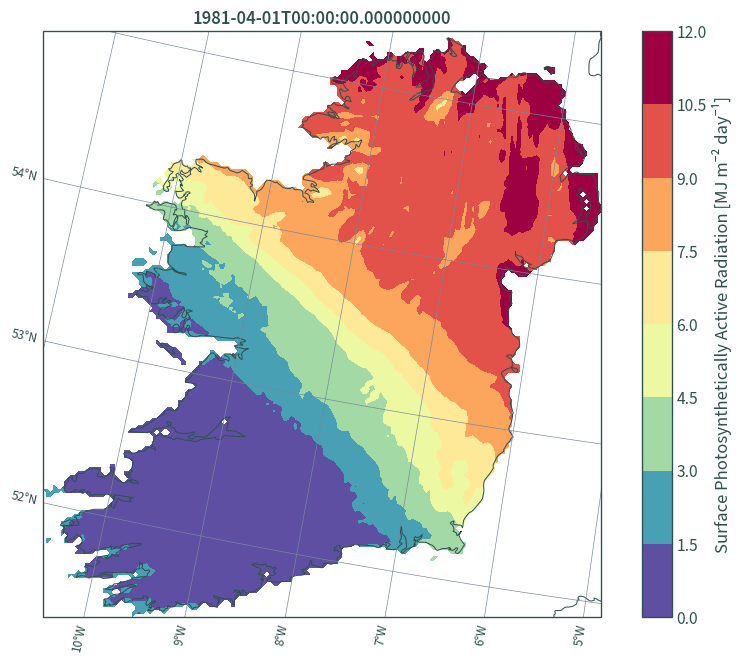

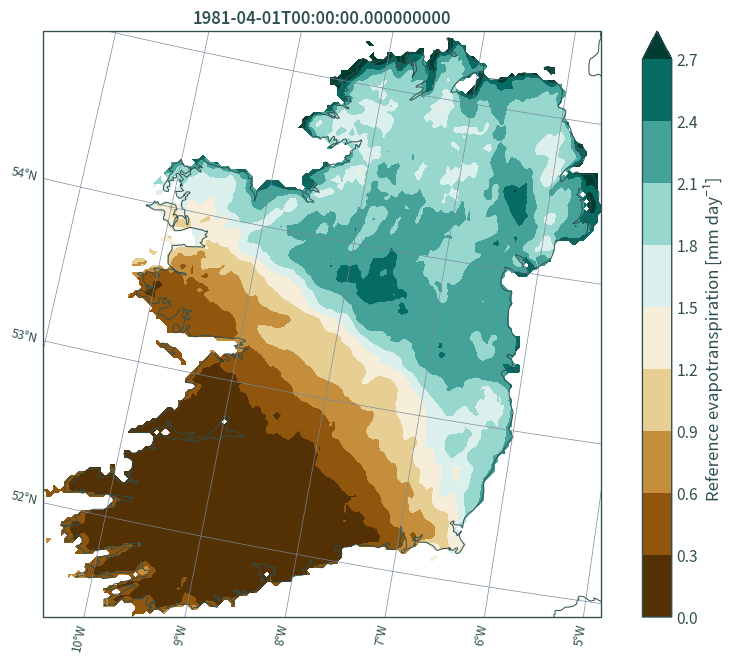

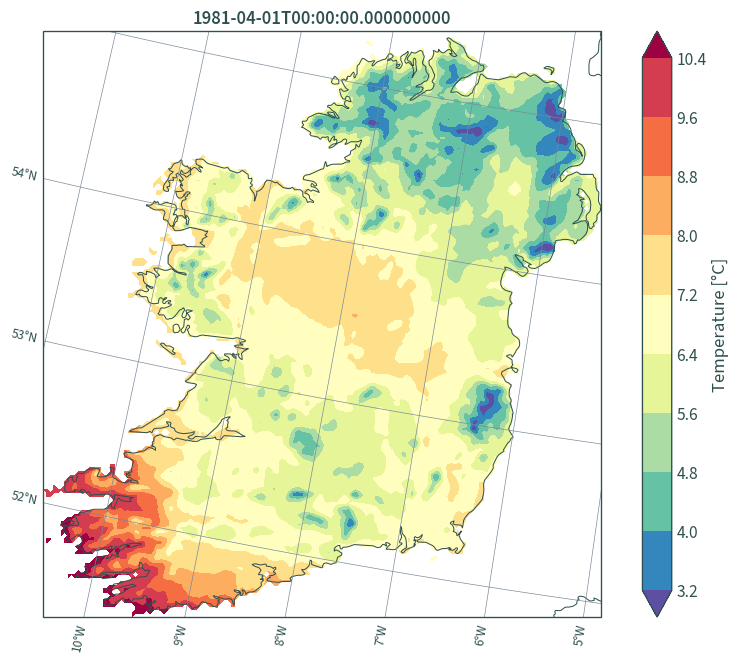

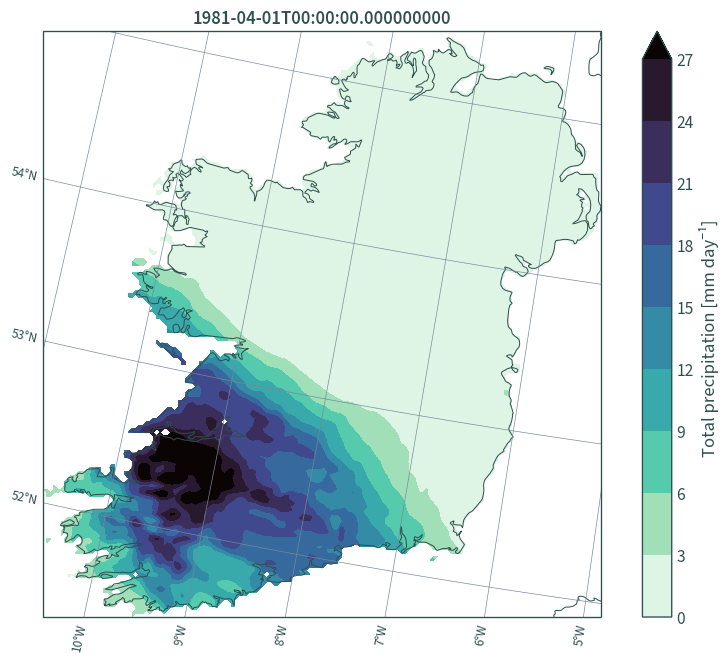

In [23]:
for var in ds.data_vars:
    plot_map(ds, var, cplt.colormap_configs(var))

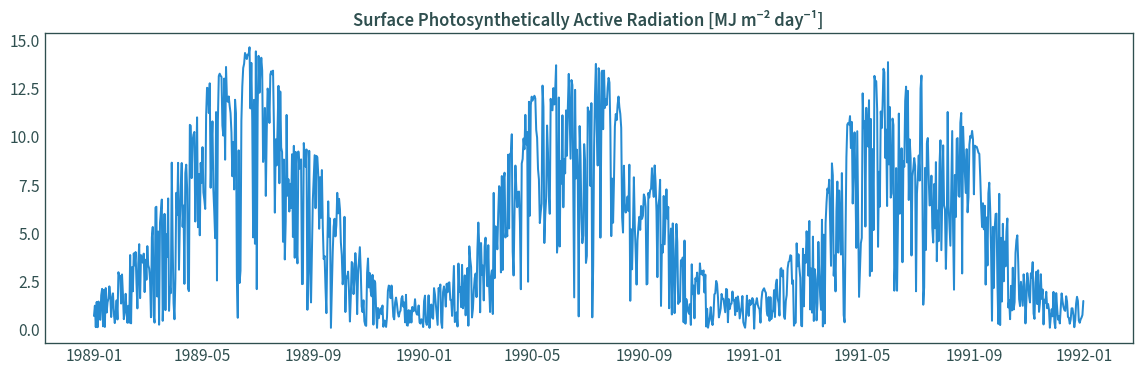

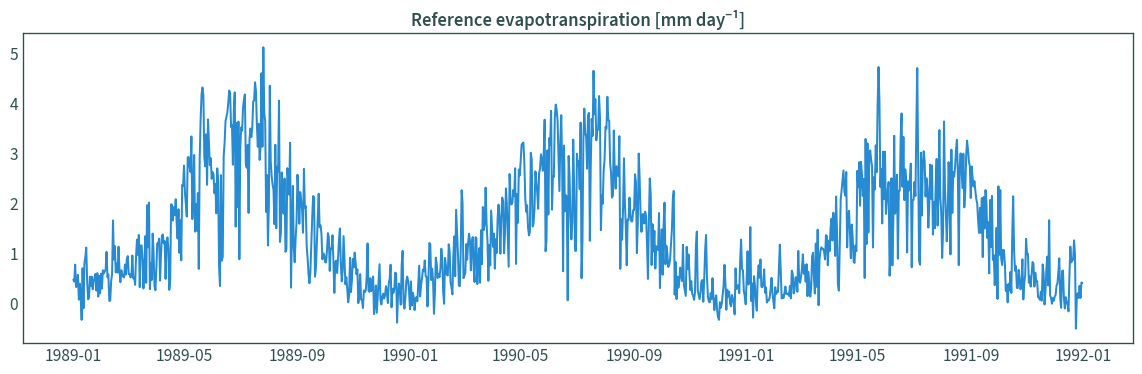

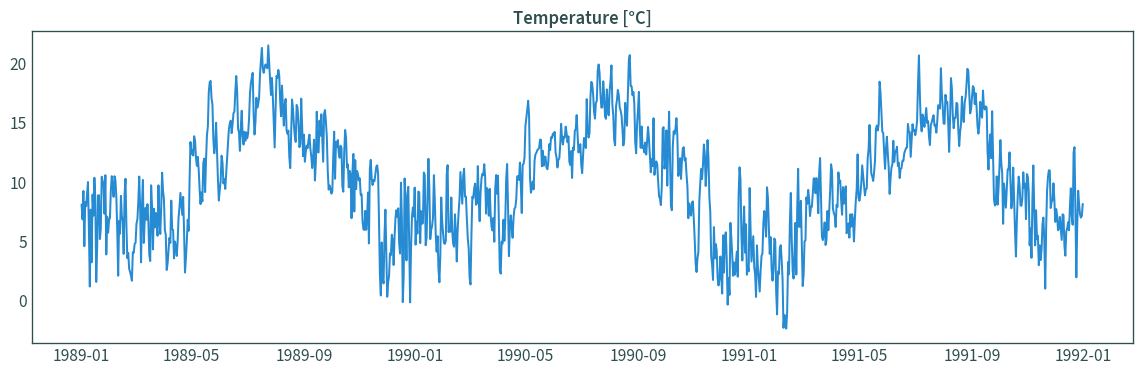

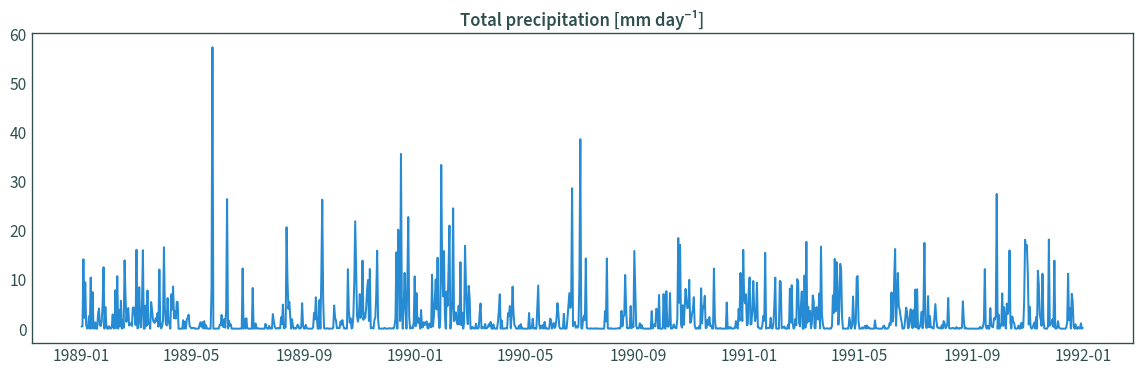

In [24]:
for var in ds.data_vars:
    plot_ts(ds, var)

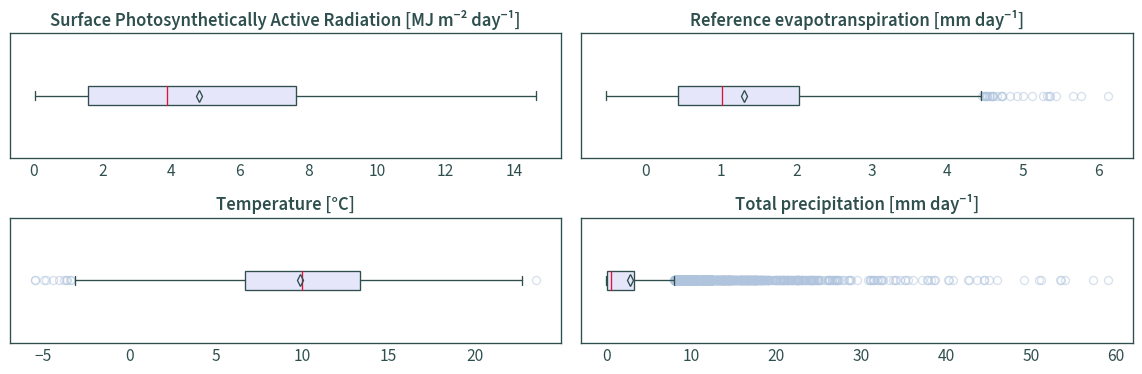

In [40]:
# box plots
ds_box = ds.sel({"x": XLON, "y": YLAT}, method="nearest").sel(
    time=slice("1981", "2005")
)

ds_df = pd.DataFrame({"time": ds_box["time"]})
for var in ds_box.data_vars:
    ds_df[var] = ds_box[var]
ds_df.set_index("time", inplace=True)

fig, axs = plt.subplots(2, 2, figsize=(12, 4))
for ax, var in zip(axs.flat, ds_box.data_vars):
    ds_df.plot.box(
        column=var, vert=False, showmeans=True, ax=ax, patch_artist=True,
        color={
            "medians": "Crimson",
            "whiskers": "DarkSlateGrey",
            "caps": "DarkSlateGrey"
        },
        boxprops={"facecolor": "Lavender", "color": "DarkSlateGrey"},
        meanprops={
            "markeredgecolor": "DarkSlateGrey",
            "marker": "d",
            "markerfacecolor": (1, 1, 0, 0)  # transparent
        },
        flierprops={
            "alpha": .5, "markeredgecolor": "LightSteelBlue", "zorder": 1
        }
    )
    ax.set_title(
        f"{ds_box[var].attrs['long_name']} [{ds_box[var].attrs['units']}]"
    )
    ax.set(yticklabels=[])
plt.tight_layout()
plt.show()

## Extend data to spin-up year

In [25]:
# copy 1981 data to 1980
ds_interp = ds.interp(
    time=pd.date_range("1980-01-01", "1980-12-31", freq="D"),
    kwargs={"fill_value": None}
)

In [26]:
ds_interp.rio.write_crs(data_crs, inplace=True)

<xarray.Dataset>
Dimensions:            (x: 158, y: 166, time: 366)
Coordinates:
  * x                  (x) float64 4.15e+05 4.175e+05 ... 8.05e+05 8.075e+05
  * y                  (y) float64 4.075e+05 4.1e+05 ... 8.175e+05 8.2e+05
    height             float64 0.0
    Lambert_Conformal  int64 ...
  * time               (time) datetime64[ns] 1980-01-01 ... 1980-12-31
    spatial_ref        int64 0
Data variables:
    PAR                (time, y, x) float32 dask.array<chunksize=(366, 85, 81), meta=np.ndarray>
    PET                (time, y, x) float32 dask.array<chunksize=(366, 86, 82), meta=np.ndarray>
    T                  (time, y, x) float32 dask.array<chunksize=(366, 85, 81), meta=np.ndarray>
    PP                 (time, y, x) float32 dask.array<chunksize=(366, 85, 81), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...
    dataset:      IE_MERA_FC3hr_3_day

In [27]:
# merge spin-up year with first two years of the main data
ds_interp = xr.combine_by_coords(
    [ds_interp, ds.sel(time=slice("1981", "1982"))]
)

In [28]:
ds_interp

<xarray.Dataset>
Dimensions:            (x: 158, y: 166, time: 1096)
Coordinates:
  * x                  (x) float64 4.15e+05 4.175e+05 ... 8.05e+05 8.075e+05
  * y                  (y) float64 4.075e+05 4.1e+05 ... 8.175e+05 8.2e+05
    height             float64 0.0
    Lambert_Conformal  int64 0
  * time               (time) datetime64[ns] 1980-01-01 ... 1982-12-31
    spatial_ref        int64 0
Data variables:
    PAR                (time, y, x) float32 dask.array<chunksize=(366, 85, 81), meta=np.ndarray>
    PET                (time, y, x) float32 dask.array<chunksize=(366, 86, 82), meta=np.ndarray>
    T                  (time, y, x) float32 dask.array<chunksize=(366, 85, 81), meta=np.ndarray>
    PP                 (time, y, x) float32 dask.array<chunksize=(366, 85, 81), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...
    dataset:      IE_MERA_FC3hr_3_day

In [29]:
# check value for the first day of the first year
ds.sel({"x": XLON, "y": YLAT}, method="nearest").isel(time=0)["T"].values

array(6.8350525, dtype=float32)

In [30]:
# check first value of spin-up year - should be nan
ds_interp.sel({"x": XLON, "y": YLAT}, method="nearest").isel(
    time=0
)["T"].values

array(nan)

In [31]:
# shift first year of the main data to the spin-up year
ds_interp = ds_interp.shift(time=-ds_interp.sel(time="1980").dims["time"])

In [32]:
# check value for the first day of the first year
ds_interp.sel({"x": XLON, "y": YLAT}, method="nearest").isel(
    time=0
)["T"].values

array(6.8350525, dtype=float32)

In [33]:
# keep only spin-up year
ds_interp = ds_interp.sel(time="1980")

In [34]:
# merge with main dataset
ds = xr.combine_by_coords([ds, ds_interp])

In [35]:
ds.rio.write_crs(data_crs, inplace=True)

<xarray.Dataset>
Dimensions:            (x: 158, y: 166, time: 9497)
Coordinates:
  * x                  (x) float64 4.15e+05 4.175e+05 ... 8.05e+05 8.075e+05
  * y                  (y) float64 4.075e+05 4.1e+05 ... 8.175e+05 8.2e+05
    height             float64 0.0
    Lambert_Conformal  int64 0
  * time               (time) datetime64[ns] 1980-01-01 ... 2005-12-31
    spatial_ref        int64 0
Data variables:
    PAR                (time, y, x) float32 dask.array<chunksize=(366, 85, 81), meta=np.ndarray>
    PET                (time, y, x) float32 dask.array<chunksize=(366, 86, 82), meta=np.ndarray>
    T                  (time, y, x) float32 dask.array<chunksize=(366, 85, 81), meta=np.ndarray>
    PP                 (time, y, x) float32 dask.array<chunksize=(366, 85, 81), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...
    dataset:      IE_MERA_FC3hr_3_day

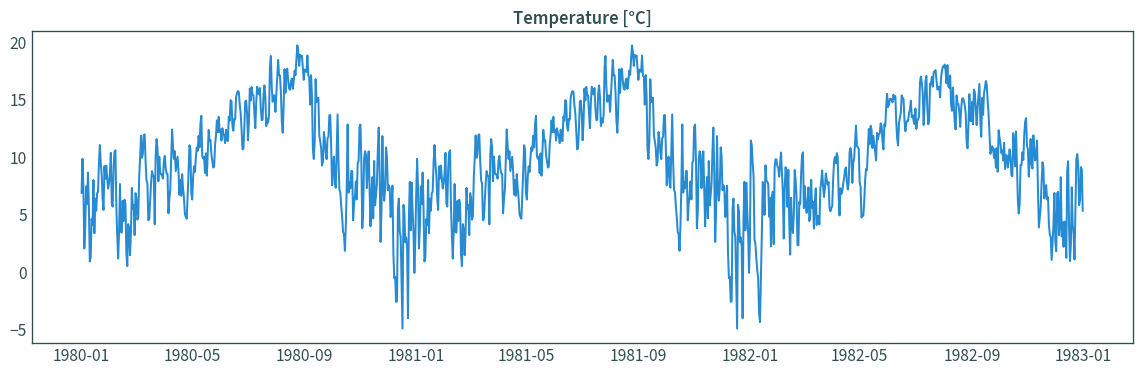

In [36]:
# visualise
# spin-up year and first year should be identical
ds_interp = ds.sel({"x": XLON, "y": YLAT}, method="nearest").sel(
    time=slice("1980", "1982")
)
plt.figure(figsize=(12, 4))
plt.plot(ds_interp["time"], ds_interp["T"])
plt.title(f"{ds['T'].attrs['long_name']} [{ds['T'].attrs['units']}]")
plt.tight_layout()
plt.show()

In [38]:
print("Last updated:", datetime.now(tz=timezone.utc))

Last updated: 2023-03-25 17:47:25.750562+00:00
